In [1]:
import re
import nltk
# to show progress bar
from tqdm import tqdm
# for pretty printing
import pprint
import spacy
import pandas as pd 
from itertools import chain
from collections import Counter
from nltk.corpus import stopwords
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))
nlp = spacy.load("es_core_news_sm")

# for topic modelling
from gensim import corpora
from gensim.models import ldamodel
from gensim.models import CoherenceModel

# for data viz
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns


posts_x = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/general/posts_result_x.csv", usecols=["texto", "polaridad"])
posts_insta = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/general/posts_result_insta.csv", usecols=["texto", "polaridad"])
posts_tiktok = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/general/posts_result_tiktok.csv")
posts_fb = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/general/posts_result_fb.csv", usecols=["texto", "polaridad"])

df_coments = pd.concat([posts_x, posts_fb, posts_insta, posts_tiktok], axis=0)
df_polaridad = pd.DataFrame(df_coments["polaridad"].copy())
df_coments = pd.DataFrame(df_coments["texto"].copy())
df_coments

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /home/milton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,texto
0,me siento profundamente orgulloso de ser parte...
1,mi compromiso es estar cerca de ustedes cada f...
2,me considero un líder capaz comprometido y val...
3,agradezco infinitamente el apoyo de quienes co...
4,han sido casi 20 años de lucha esfuerzo y dedi...
...,...
68,"No me gusta, me encanta!!! #DrCarlosLomeli #D..."
69,Es un honor estar con Obrador! 🙌🏻 #DrCarlosLom...
70,Es que si está muy buena la canción 😅 #DrCarlo...
71,¡Feliz cumple 481 Guadalajara querida! #SanVal...


In [2]:
def data_clean(df):
    """
    Parameters
    ----------
    df : DataFrame con columnas
            'texto','comentarisos'repost', 'likes','views'.
    Returns
    -------
    df_posts : DataFrame
        Retorna dos DataFrames limpios:
            El primero con las columnas 'coment','rt','like','views'.
            El segundo con las columnas 'texto', 'tokens'.
    """
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'\d', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'[.,;!?]', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'jaja(ja)*', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r"(, '[\W\.]')",r"", str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
    df = df.fillna('')
    return df

df_coments= data_clean(df_coments)
df_coments

,texto
0,me siento profundamente orgulloso de ser parte...
1,mi compromiso es estar cerca de ustedes cada f...
2,me considero un líder capaz comprometido y val...
3,agradezco infinitamente el apoyo de quienes co...
4,han sido casi años de lucha esfuerzo y dedica...
...,...
68,no me gusta me encanta drcarloslomeli drcarlo...
69,es un honor estar con obrador drcarloslomeli ...
70,es que si está muy buena la canción drcarlosl...
71,feliz cumple guadalajara querida sanvalentin ...


In [3]:
nlp.disable_pipes('ner')
print(nlp.pipe_names)
dataset = df_coments['texto']
docs = []
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and 
          not token.is_stop)]
    docs.append(pt)
counts_word_occurence = Counter(chain(*[x for x in docs]))
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>1] for text in docs]  
docs_length=len(docs)
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>4}
docs =  [[lemma for lemma in text if counts_word_percentage[lemma]<4] for text in docs]


/home/milton/.local/lib/python3.10/site-packages/spacy/language.py:1067: DeprecationWarning: [W096] The method `nlp.disable_pipes` is now deprecated - use `nlp.select_pipes` instead.
  warnings.warn(Warnings.W096, DeprecationWarning)


['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer']


100%|██████████| 359/359 [00:03<00:00, 100.14it/s]


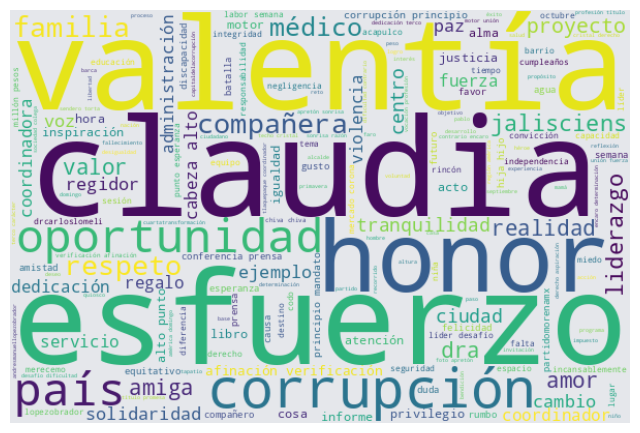

In [4]:
######Nube de Palabras########################
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Limpieza de Stop_words
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy","dd","drcarloslomeli","jajaja"
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da","doccast","vas","jajajaja","dio","par",
                "drcarloslomeli", "doc", "dr", "jajajajajajaja", "vez", "dra"))

docs = [word for word in docs if word not in stop_words]
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in docs for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)

# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Cículo
# Crear una máscara en blanco para establecer un fondo transparente

# Crear el objeto WordCloud
wordcloud = WordCloud(width=600, height=400, background_color="#e5e7eb").generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(8, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.savefig("posts.png", dpi=200, bbox_inches="tight")
plt.show()

In [36]:

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas



df_coments['bigramas_spacy'] = df_coments['texto'].apply(generar_bigramas_spacy)


from nltk.collocations import *

flatten_corpus = [w for l in df_coments.bigramas_spacy for w in l]

treshold = 3

bigrams = [bigram for bigram in flatten_corpus if len(bigram[0])>treshold and len(bigram[1])>treshold]

bigram_measure = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(bigrams)
finder.apply_freq_filter(6)
colocaciones = finder.nbest(bigram_measure.pmi,10)
print(type(colocaciones))
colocaciones = pd.DataFrame(colocaciones, columns=['Columna1', 'Columna2'])

colocaciones["colocacion"] = colocaciones.Columna1 + ' ' + colocaciones.Columna2
columnas = ['Columna1', 'Columna2']
colocaciones = colocaciones.drop(columnas, axis=1)
colocaciones

<class 'list'>


,colocacion
0,verificación recaudatoria
1,actuamos bajo
2,combatido permanentemente
3,corazón encendido
4,segundo informe
5,estoy convencido
6,claudia sheinbaum
7,puede lograr
8,nosotros actuamos
9,admiro profundamente


[['hombre', 'proyecto', 'cuartatransformación'],
 ['foto', 'apretón', 'sonrisa', 'razón'],
 ['líder', 'desafío', 'dificultad', 'contrario', 'encaro', 'determinación',
  'motor', 'unión', 'fuerza'],
 [], ['esfuerzo', 'dedicación', 'terco', 'carácter', 'valentía', 'honor'],
 ['amor'], ['felicidad', 'alma'],
 ['vocación', 'profesión', 'título', 'promesa', 'salud', 'médico', 'valentía',
  'valor', 'médico', 'sociedad', 'colega'],
 ['birria', 'barca', 'panza'], ['sendero'], ['torta'],
 ['felicitación', 'amiga', 'compañera', 'motivo', 'cumpleaños', 'cumpleaños'],
 ['tlaquepaque', 'coordinador', 'amor'],
 ['techo', 'cristal', 'derecho', 'aspiración'],
 ['partidomorenamx', 'invitación'],
 ['respeto', 'integridad', 'labor', 'semana'],
 ['alto', 'región', 'américa', 'domingo'], ['privilegio'],
 ['oriente', 'paz', 'tranquilidad', 'desarrollo', 'simpatizante', 'partido'],
 [],
 ['principio', 'partidomorenamx', 'organización', 'movilización', 'suma',
  'voluntad', 'causa', 'equitativo'],
 ['resulta

<bound method DataFrame.to_numpy of     number_of_topics          variable      value
0                 10  u_mass_coherence -17.780842
1                 11  u_mass_coherence -17.231180
2                 12  u_mass_coherence -16.997882
3                 13  u_mass_coherence -17.915337
4                 14  u_mass_coherence -17.619888
5                 15  u_mass_coherence -18.083185
6                 16  u_mass_coherence -18.077264
7                 17  u_mass_coherence -17.286658
8                 18  u_mass_coherence -17.865067
9                 19  u_mass_coherence -17.924411
10                20  u_mass_coherence -18.168466
11                21  u_mass_coherence -17.139462
12                22  u_mass_coherence -17.789124
13                23  u_mass_coherence -18.283454
14                24  u_mass_coherence -18.033984
15                25  u_mass_coherence -18.011773
16                26  u_mass_coherence -18.111504
17                27  u_mass_coherence -17.839006
18            

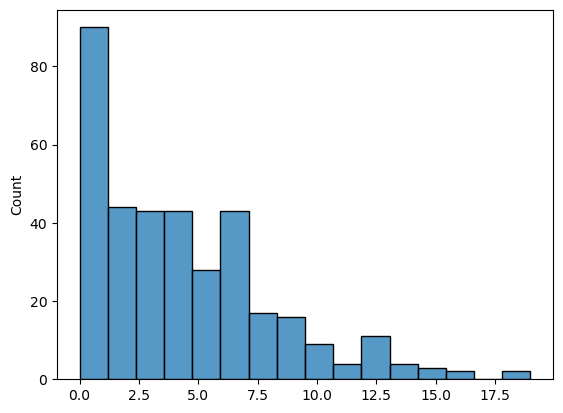

In [23]:
###############################################
pp = pprint.PrettyPrinter(compact=True)
pp.pprint(docs)
lengths =  [len(x) for x in docs]
sns.histplot(lengths)
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):

        # defining the model
        lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=26, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()

        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()

        values = [topics, u_mass_coherence, c_v_coherence]

        scores.append(values)

    return scores

scores = calculate_coherence(dictionary, corpus, docs, 10, 30)
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])
df.to_numpy

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

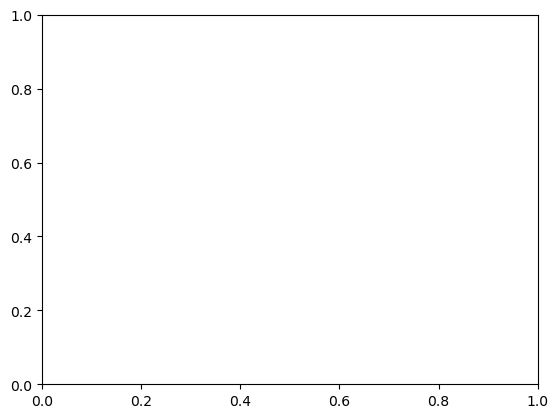

In [24]:
# Plotting u_mass_coherence
sns.lineplot(data=df.loc[df['variable'] == 'u_mass_coherence'], x="number_of_topics", y="value").set_title('c_v coherence')

In [25]:
###########Modelo LDA Topics##########################
lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, alpha='auto', eval_every=5)

# print topics
lda_model.print_topics(-1)


# print topics
topics = lda_model.print_topics(-1)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

########################################
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(viz, 'ldavis_visualization_posts.html')

(0, '0.038*"realidad" + 0.025*"merecemo" + 0.025*"privilegio" + 0.019*"tiempo" + 0.019*"primavera" + 0.018*"corrupción" + 0.013*"esperanza" + 0.013*"respeto" + 0.013*"honor" + 0.013*"proyecto"')
(1, '0.034*"principio" + 0.033*"claudia" + 0.026*"corrupción" + 0.026*"mandato" + 0.019*"dedicación" + 0.017*"proyecto" + 0.017*"compañero" + 0.013*"libro" + 0.013*"seguridad" + 0.013*"compañera"')
(2, '0.043*"peso" + 0.029*"convicción" + 0.022*"salud" + 0.022*"familia" + 0.022*"servicio" + 0.022*"agua" + 0.022*"situacion" + 0.015*"conciencia" + 0.015*"trabajo" + 0.015*"oportunidad"')
(3, '0.034*"inspiración" + 0.023*"motor" + 0.021*"liderazgo" + 0.021*"voz" + 0.021*"cambio" + 0.019*"honor" + 0.019*"derecho" + 0.019*"país" + 0.019*"domingo" + 0.014*"educación"')
(4, '0.050*"verificación" + 0.039*"afinación" + 0.034*"jalisciens" + 0.028*"esperanza" + 0.023*"abrazo" + 0.017*"cabeza" + 0.017*"alto" + 0.017*"descalificación" + 0.017*"coordinador" + 0.017*"dicha"')
(5, '0.055*"respeto" + 0.031*"sema

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

In [26]:
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.091412 -0.047347       1        1  11.849776
9     -0.047578 -0.205654       2        1  11.742021
6     -0.079649  0.009003       3        1  11.714230
1      0.130835 -0.060054       4        1  11.108253
5      0.024063  0.141804       5        1  10.356751
2     -0.169132  0.000563       6        1   9.080762
4     -0.138355  0.029408       7        1   8.819926
8      0.002101  0.083270       8        1   8.576699
0      0.085369  0.080447       9        1   8.471440
7      0.100934 -0.031439      10        1   8.280142, topic_info=             Term       Freq      Total Category  logprob  loglift
54        respeto  12.000000  12.000000  Default  30.0000  30.0000
344  verificación  11.000000  11.000000  Default  29.0000  29.0000
210       informe   8.000000   8.000000  Default  28.0000  28.0000
334          peso   6.000000   6.000000  Default  27.0000  27.0000
349     afinación   6.000000   6.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
236       claudia   1.805672  12.352625  Topic10  -4.2740   0.5684
22           amor   0.945969   9.060422  Topic10  -4.9205   0.2318
84    inspiración   0.945875  10.627496  Topic10  -4.9206   0.0722
170       ejemplo   0.945852   7.337118  Topic10  -4.9206   0.4427
269     capacidad   0.945848   4.018877  Topic10  -4.9206   1.0446

[441 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
337       3  0.218439    abrazo
337       7  0.655316    abrazo
254       3  0.833022  acapulco
251       4  0.283300    acción
251       5  0.566600    acción
...     ...       ...       ...
182       5  0.390912    vuelta
182       7  0.195456    vuelta
182       9  0.195456    vuelta
169       3  0.335982      zona
169       4  0.671964      zona

[786 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 7, 2, 6, 3, 5, 9, 1, 8])

In [37]:

topic_data = []
for topic_id, topic in topics:
    topic_words = [word.split('*')[1] for word in topic.split('+')]
    topic_data.append([topic_id, ", ".join(topic_words)])

# DataFrame a partir de los datos de tópicos
df_topics = pd.DataFrame(topic_data, columns=["ID de Tópico", "Palabras Clave"])

freq = viz[0]

topicos = pd.concat([df_topics, freq, colocaciones], axis=1)
topicos.to_csv("topicos_posts.csv")
topicos

,ID de Tópico,Palabras Clave,x,y,topics,cluster,Freq,colocacion
0,0,"""realidad"" , ""merecemo"" , ""privilegio"" , ""tiem...",0.085369,0.080447,9,1,8.471440,verificación recaudatoria
1,1,"""principio"" , ""claudia"" , ""corrupción"" , ""mand...",0.130835,-0.060054,4,1,11.108253,actuamos bajo
2,2,"""peso"" , ""convicción"" , ""salud"" , ""familia"" , ...",-0.169132,0.000563,6,1,9.080762,combatido permanentemente
3,3,"""inspiración"" , ""motor"" , ""liderazgo"" , ""voz"" ...",0.091412,-0.047347,1,1,11.849776,corazón encendido
4,4,"""verificación"" , ""afinación"" , ""jalisciens"" , ...",-0.138355,0.029408,7,1,8.819926,segundo informe
5,5,"""respeto"" , ""semana"" , ""paz"" , ""integridad"" , ...",0.024063,0.141804,5,1,10.356751,estoy convencido
6,6,"""país"" , ""chiva"" , ""ciudad"" , ""corrupción"" , ""...",-0.079649,0.009003,3,1,11.714230,claudia sheinbaum
7,7,"""esfuerzo"" , ""cabeza"" , ""objetivo"" , ""dra"" , ""...",0.100934,-0.031439,10,1,8.280142,puede lograr
8,8,"""fuerza"" , ""amiga"" , ""desafío"" , ""motor"" , ""pr...",0.002101,0.083270,8,1,8.576699,nosotros actuamos
9,9,"""informe"" , ""oportunidad"" , ""valentía"" , ""esfu...",-0.047578,-0.205654,2,1,11.742021,admiro profundamente
